# German Credit Case Study

## Problem Statement

### Context

To minimize loss from the bank’s perspective, the bank needs a decision rule regarding whom to approve the loan and whom not to. An applicant’s demographic and socio-economic profiles are considered by loan managers before a decision is taken regarding his/her loan application.
In this dataset, each entry represents a person who takes credit from a bank. Each person is classified as a good or bad credit risk according to the set of attributes. 
 

### Objective:
The objective is to build a predictive model on this data to help the bank decide on whether to approve a loan to a prospective applicant.

 
### Dataset:
- Age (Numeric: Age in years)
- Sex (Categories: male, female)
- Job (Categories: unskilled and non-resident, unskilled and resident, skilled, highly skilled)
- Housing (Categories: own, rent, or free)
- Saving accounts (Categories: little, moderate, quite rich, rich)
- Checking account (Categories: little, moderate, rich)
- Credit amount (Numeric: Amount of credit in DM - Deutsche Mark)
- Duration (Numeric: Duration for which the credit is given in months)
- Purpose (Categories: car, furniture/equipment,radio/TV, domestic appliances, repairs, education, business, vacation/others)
- Risk (0 - Person is not at risk, 1 - Person is at risk(defaulter))

## Importing Libraries

In [474]:
# Suppressing warning
import warnings
warnings.filterwarnings('ignore')

# Libraries for numerical calculations and manipulation of data
import numpy as np
import pandas as pd

# Libraries for visulaization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries for classification
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, f1_score,
    recall_score, precision_score, confusion_matrix, precision_recall_curve)

# Setting the background theme and font scale for figures
sns.set_theme(style = 'darkgrid', font_scale = 1.15)

# To restrict the float value to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Overview of Dataset

In [4]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

# Importing the dataset
data_orig = pd.read_csv('/content/drive/MyDrive/Python_files/German_Credit.csv')
# Ensuring original data remains unchanged
df = data_orig.copy()

Mounted at /content/drive/


In [5]:
# Peeking first five rows
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk,Purpose
0,67,male,skilled,own,little,little,1169,6,0,radio/TV
1,22,female,skilled,own,little,moderate,5951,48,1,radio/TV
2,49,male,unskilled_and_non-resident,own,little,little,2096,12,0,education
3,45,male,skilled,free,little,little,7882,42,0,furniture/equipment
4,53,male,skilled,free,little,little,4870,24,1,car


In [6]:
# Peeking last five rows
df.tail()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk,Purpose
995,31,female,unskilled_and_non-resident,own,little,little,1736,12,0,furniture/equipment
996,40,male,highly skilled,own,little,little,3857,30,0,car
997,38,male,skilled,own,little,little,804,12,0,radio/TV
998,23,male,skilled,free,little,little,1845,45,1,radio/TV
999,27,male,skilled,own,moderate,moderate,4576,45,0,car


In [7]:
# Checking the shape of dataset
print('The dataset has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

The dataset has 1000 rows and 10 columns.


In [8]:
# General summary of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   object
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Risk              1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [10]:
# Statistical summary (numerical)
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
Age,1000.00,35.55,11.38,19.00,27.00,33.00,42.00,75.00
Credit amount,1000.00,3271.26,2822.74,250.00,1365.50,2319.50,3972.25,18424.00
Duration,1000.00,20.90,12.06,4.00,12.00,18.00,24.00,72.00
Risk,1000.00,0.30,0.46,0.00,0.00,0.00,1.00,1.00


In [11]:
# Statistical summary (categorical)
df.describe(include = ['object', 'category']).T

,count,unique,top,freq
Sex,1000,2,male,690
Job,1000,3,skilled,630
Housing,1000,3,own,713
Saving accounts,1000,4,little,786
Checking account,1000,3,moderate,472
Purpose,1000,8,car,337


In [16]:
# Checking for missing values and duplicates
print('The dataset has {} missing values.'.format(df.isnull().sum().sum()))
print('The dataset has {} duplicated entries.'.format(df.duplicated().sum()))

The dataset has 0 missing values.
The dataset has 0 duplicated entries.


## Univariate Analysis

In [17]:
# Function for annotating the bars in a countplot
def countplot_labeling(cntplt, data, perc = True):
  ''' This function gets a countplot and the dataset that has generated
  the plot to produce the values corresponding to each bar (category).
  If perc = True, percentages will be shown.'''

  total = data.shape[0]  # total number of values in the dataset
  for p in cntplt.patches:
        if perc == True:
          # percentage of each category
          label = "{:.1f}%".format(100*p.get_height()/total)
        else:
          label = round(p.get_height(),1)  # count of each category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        # annotate the bar
        cntplt.annotate(label, (x, y), ha = "center", va = "center", size=12, xytext=(0, 5), textcoords = "offset points")  

### Categorical Variables

In [22]:
# Separating categorical variables from numerical ones
cat_vars = df.select_dtypes(include = ['object', 'category']).columns.tolist()
cat_vars.append('Risk')
cat_vars

['Sex',
 'Job',
 'Housing',
 'Saving accounts',
 'Checking account',
 'Purpose',
 'Risk']

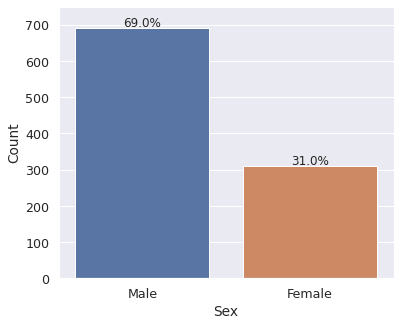

In [29]:
# Distribution of sex

plt.figure(figsize = (6, 5));
cntplt = sns.countplot(data = df, x = 'Sex');
countplot_labeling(cntplt, df);
plt.ylabel('Count');
plt.ylim(0, 750);
cntplt.set_xticklabels(['Male', 'Female']);

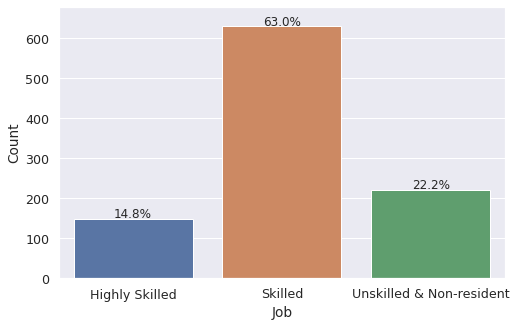

In [32]:
# Distribution of job

plt.figure(figsize = (8, 5));
cntplt = sns.countplot(data = df, x = 'Job', order = ['highly skilled', 'skilled', 'unskilled_and_non-resident']);
countplot_labeling(cntplt, df);
plt.ylabel('Count');
plt.ylim(0, 680);
cntplt.set_xticklabels(['Highly Skilled', 'Skilled', 'Unskilled & Non-resident']);

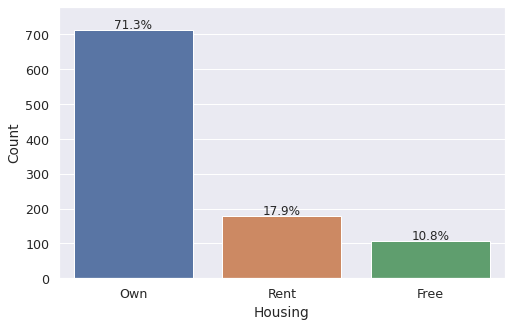

In [36]:
# Distribution of housing

plt.figure(figsize = (8, 5));
cntplt = sns.countplot(data = df, x = 'Housing', order = ['own', 'rent', 'free']);
countplot_labeling(cntplt, df);
plt.ylabel('Count');
plt.ylim(0, 780);
cntplt.set_xticklabels(['Own', 'Rent', 'Free']);

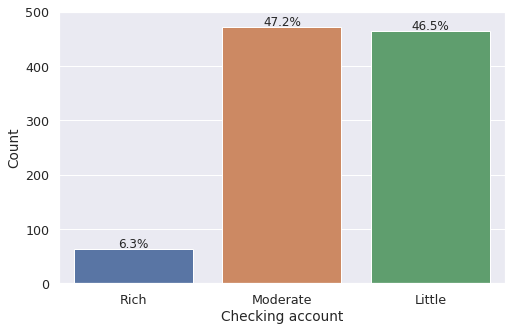

In [40]:
# Distribution of checking accounts

plt.figure(figsize = (8, 5));
cntplt = sns.countplot(data = df, x = 'Checking account', order = ['rich', 'moderate', 'little']);
countplot_labeling(cntplt, df);
plt.ylabel('Count');
plt.ylim(0, 500);
cntplt.set_xticklabels(['Rich', 'Moderate', 'Little']);

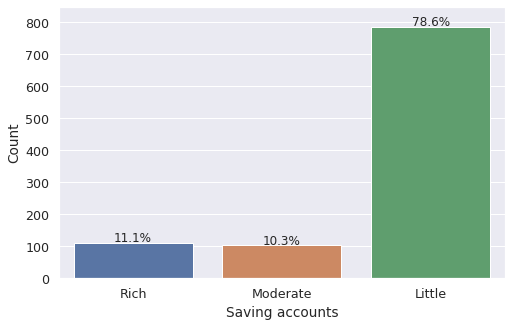

In [46]:
# Distribution of saving accounts

# We first merge rich and quite rich categories
df.loc[df['Saving accounts'] == 'quite rich', 'Saving accounts'] = 'rich'

# Distribution plots
plt.figure(figsize = (8, 5));
cntplt = sns.countplot(data = df, x = 'Saving accounts', order = ['rich', 'moderate', 'little']);
countplot_labeling(cntplt, df);
plt.ylabel('Count');
plt.ylim(0, 850);
cntplt.set_xticklabels(['Rich', 'Moderate', 'Little']);

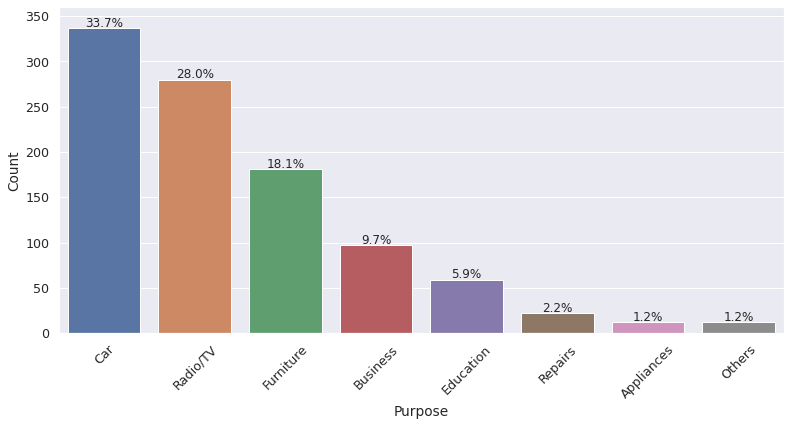

In [59]:
# Distribution of purpose

plt.figure(figsize = (13, 6));
cntplt = sns.countplot(data = df, x = 'Purpose', order = df.Purpose.value_counts().index.tolist());
countplot_labeling(cntplt, df);
plt.ylabel('Count');
plt.xticks(rotation = 45);
plt.ylim(0, 360);
cntplt.set_xticklabels(['Car', 'Radio/TV', 'Furniture', 'Business', 'Education',
                        'Repairs', 'Appliances', 'Others']);

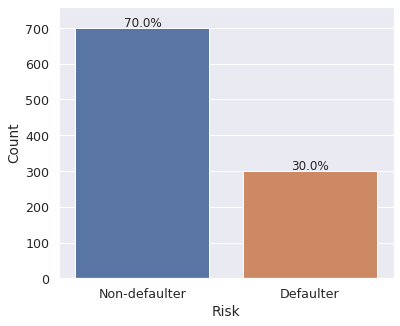

In [72]:
# Distribution of risk

plt.figure(figsize = (6, 5));
cntplt = sns.countplot(data = df, x = 'Risk');
countplot_labeling(cntplt, df);
plt.ylabel('Count');
plt.ylim(0, 760);
cntplt.set_xticklabels(['Non-defaulter', 'Defaulter']);

### Numerical Variables

In [23]:
# Separating categorical variables from numerical ones
num_vars = df.select_dtypes(include = np.number).columns.tolist()
num_vars.remove('Risk')
num_vars

['Age', 'Credit amount', 'Duration']

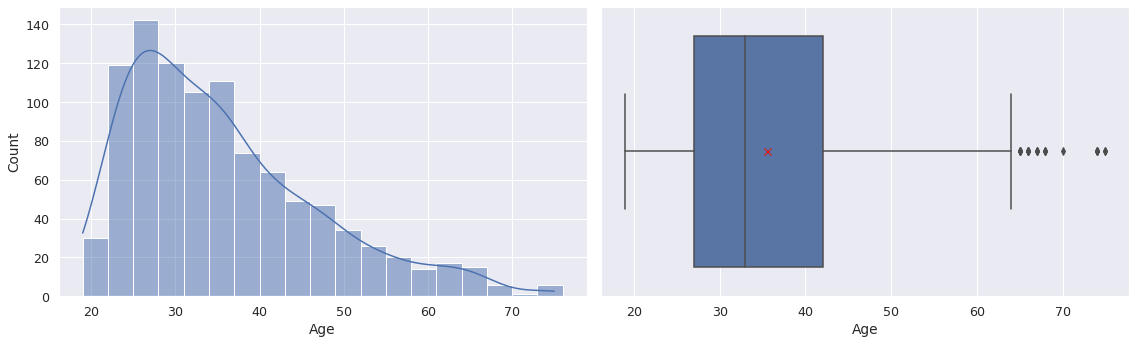

In [285]:
# Distribution of age

plt.figure(figsize = (16, 5));
plt.subplot(121);
sns.histplot(data = df, x = 'Age', kde = True, binwidth = 3);
plt.subplot(122);
sns.boxplot(data = df, x = 'Age', showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '7'});
plt.tight_layout();

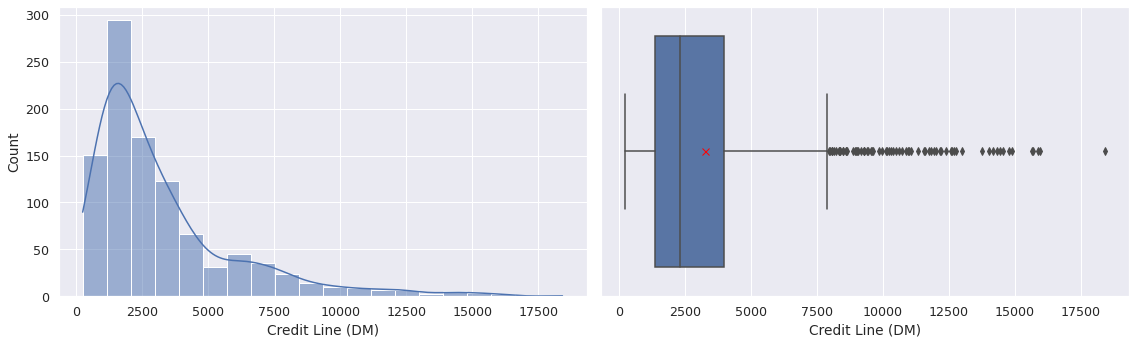

In [83]:
# Distribution of credit amount (credit in Deutsche Mark)

plt.figure(figsize = (16, 5));
plt.subplot(121);
sns.histplot(data = df, x = 'Credit amount', kde = True, bins = 20);
plt.xlabel('Credit Amount (DM)');
plt.subplot(122);
sns.boxplot(data = df, x = 'Credit amount', showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '7'});
plt.xlabel('Credit Amount (DM)');
plt.tight_layout();

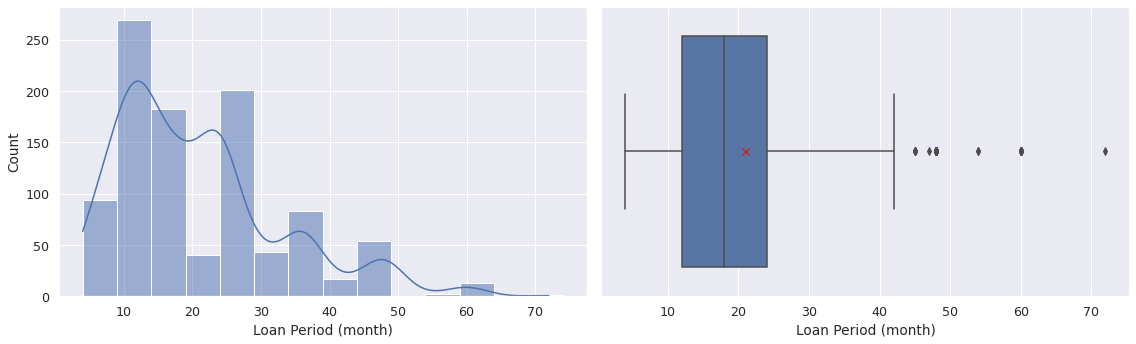

In [297]:
# Distribution of duration (loan period)

plt.figure(figsize = (16, 5));
plt.subplot(121);
sns.histplot(data = df, x = 'Duration', kde = True, binwidth = 5);
plt.xlabel('Loan Period (month)');
plt.subplot(122);
sns.boxplot(data = df, x = 'Duration', showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '7'});
plt.xlabel('Loan Period (month)');
plt.tight_layout();

## Bivariate Analysis

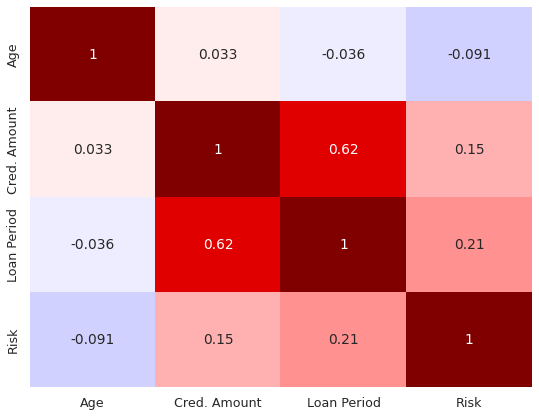

In [279]:
# Heatmap of numerical vars + Risk

plt.figure(figsize = (9, 7));
corrplt = sns.heatmap(data = df.corr(), annot = True, cbar = False, cmap = 'seismic', vmin = -1, vmax = 1);
corrplt.set_xticklabels(labels = ['Age', 'Cred. Amount', 'Loan Period', 'Risk']);
corrplt.set_yticklabels(labels = ['Age', 'Cred. Amount', 'Loan Period', 'Risk']);

## Data Preprocessing

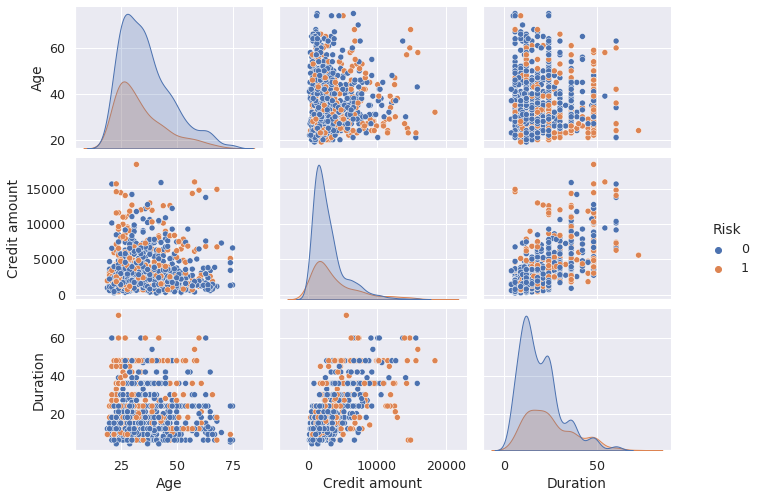

In [112]:
# Pairplot of numerical vars + Risk

pairplt = sns.pairplot(data = df, diag_kind = 'kde', hue = 'Risk');
pairplt.fig.set_size_inches(11, 7);

### Risk vs. Categorical Variables 

**`Risk vs. Sex`**

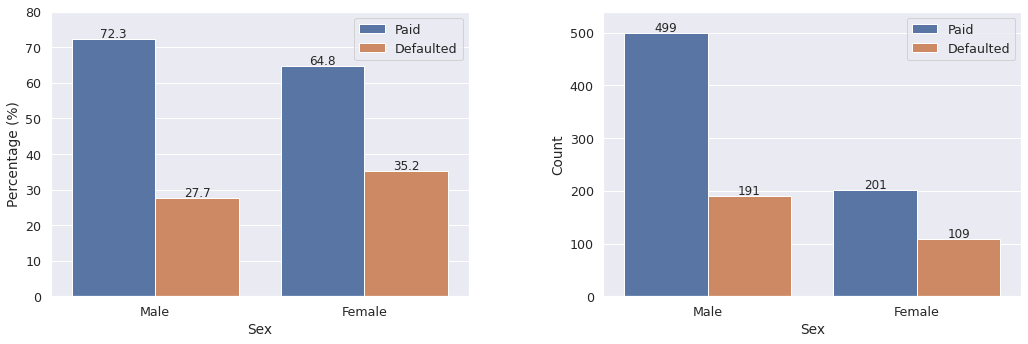

In [187]:
# Making a dataframe out of the crosstab of risk and sex
ctab = pd.crosstab(df['Sex'], df['Risk'], normalize = 'index');
ctab_df = ctab.stack().reset_index()
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df.value = ctab_df.value*100
ctab_df.loc[ctab_df['Risk'] == 0, 'Risk'] = 'Paid'
ctab_df.loc[ctab_df['Risk'] == 1, 'Risk'] = 'Defaulted'

plt.figure(figsize = (14.5, 5))
# Barplot of percentages
plt.subplot(121)
barplt = sns.barplot(data = ctab_df, x = 'Sex', y = 'value', hue = 'Risk', order = ['male', 'female'], 
                     hue_order = ['Paid', 'Defaulted']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.legend(title = '', loc = 'upper right');
plt.xlabel('Sex');
plt.ylabel('Percentage (%)')
barplt.set_xticklabels(labels = ['Male', 'Female']);
plt.ylim(0, 80);
# Countplot of counts
plt.subplot(122)
cntplt = sns.countplot(data = df, x = 'Sex', hue = 'Risk', order = ['male', 'female'], hue_order = [0, 1]);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Sex');
plt.ylabel('Count');
cntplt.set_xticklabels(labels = ['Male', 'Female']);
plt.legend(labels = ['Paid', 'Defaulted'], title = '', loc = 'upper right');
plt.ylim(0, 540);
plt.tight_layout(w_pad = 6)

**`Risk vs. Job`**

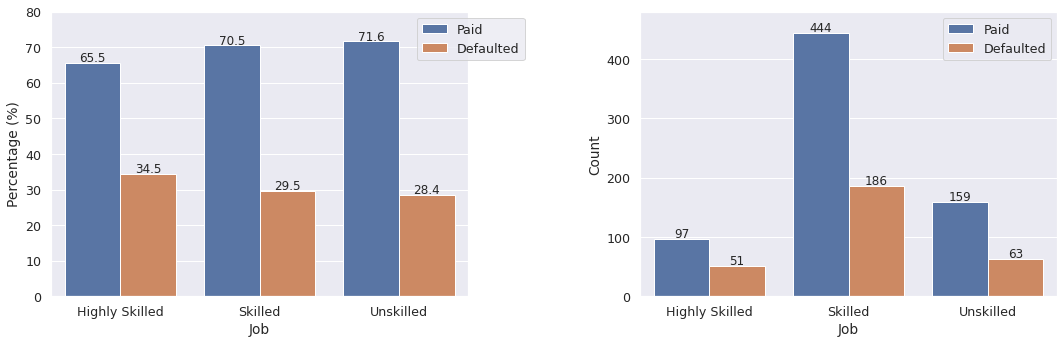

In [210]:
# Making a dataframe out of the crosstab of risk and job
ctab = pd.crosstab(df['Job'], df['Risk'], normalize = 'index');
ctab_df = ctab.stack().reset_index()
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df.loc[ctab_df['Job'] == 'highly skilled', 'Job'] = 'Highly Skilled'
ctab_df.loc[ctab_df['Job'] == 'skilled', 'Job'] = 'Skilled'
ctab_df.loc[ctab_df['Job'] == 'unskilled_and_non-resident', 'Job'] = 'Unskilled'
ctab_df.loc[ctab_df['Risk'] == 0, 'Risk'] = 'Paid'
ctab_df.loc[ctab_df['Risk'] == 1, 'Risk'] = 'Defaulted'
ctab_df.value = ctab_df.value*100

plt.figure(figsize = (15, 5))
# Barplot of percentages
plt.subplot(121)
barplt = sns.barplot(data = ctab_df, x = 'Job', y = 'value', hue = 'Risk', hue_order = ['Paid', 'Defaulted']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.legend(title = '', bbox_to_anchor = [1.15, 1.], loc = 'upper right');
plt.xlabel('Job');
plt.ylabel('Percentage (%)')
#barplt.set_xticklabels(labels = ['Male', 'Female']);
plt.ylim(0, 80);
# Countplot of counts
plt.subplot(122)
cntplt = sns.countplot(data = df, x = 'Job', hue = 'Risk', hue_order = [0, 1], 
                       order = ['highly skilled', 'skilled', 'unskilled_and_non-resident']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Job');
plt.ylabel('Count');
cntplt.set_xticklabels(labels = ['Highly Skilled', 'Skilled', 'Unskilled']);
plt.legend(labels = ['Paid', 'Defaulted'], title = '', loc = 'upper right');
plt.ylim(0, 480);
plt.tight_layout(w_pad = 5)

**`Risk vs. Housing`**

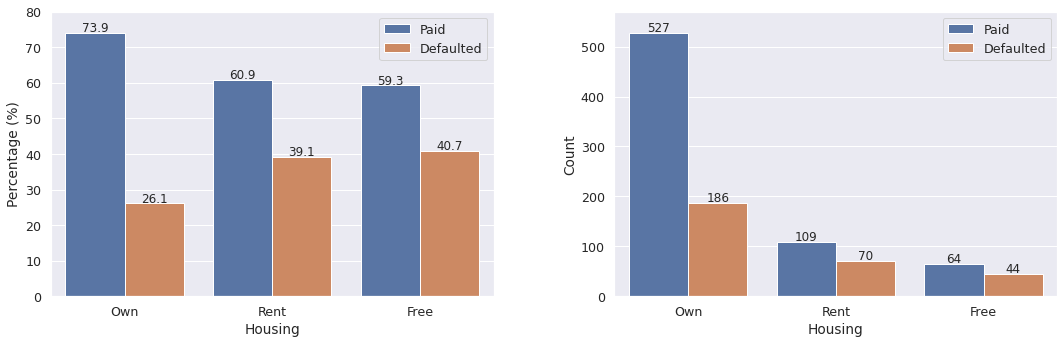

In [209]:
# Making a dataframe out of the crosstab of risk and housing
ctab = pd.crosstab(df['Housing'], df['Risk'], normalize = 'index');
ctab_df = ctab.stack().reset_index()
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df.loc[ctab_df['Risk'] == 0, 'Risk'] = 'Paid'
ctab_df.loc[ctab_df['Risk'] == 1, 'Risk'] = 'Defaulted'
ctab_df.value = ctab_df.value*100

plt.figure(figsize = (15, 5))
# Barplot of percentages
plt.subplot(121)
barplt = sns.barplot(data = ctab_df, x = 'Housing', y = 'value', hue = 'Risk', hue_order = ['Paid', 'Defaulted'],
                     order = ['own', 'rent', 'free']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.legend(title = '', loc = 'upper right');
plt.xlabel('Housing');
plt.ylabel('Percentage (%)')
barplt.set_xticklabels(labels = ['Own', 'Rent', 'Free']);
plt.ylim(0, 80);
# Countplot of counts
plt.subplot(122)
cntplt = sns.countplot(data = df, x = 'Housing', hue = 'Risk', hue_order = [0, 1], order = ['own', 'rent', 'free']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Housing');
plt.ylabel('Count');
cntplt.set_xticklabels(labels = ['Own', 'Rent', 'Free']);
plt.legend(labels = ['Paid', 'Defaulted'], title = '', loc = 'upper right');
plt.ylim(0, 570);
plt.tight_layout(w_pad = 5)

**`Risk vs. Checking Accounts`**

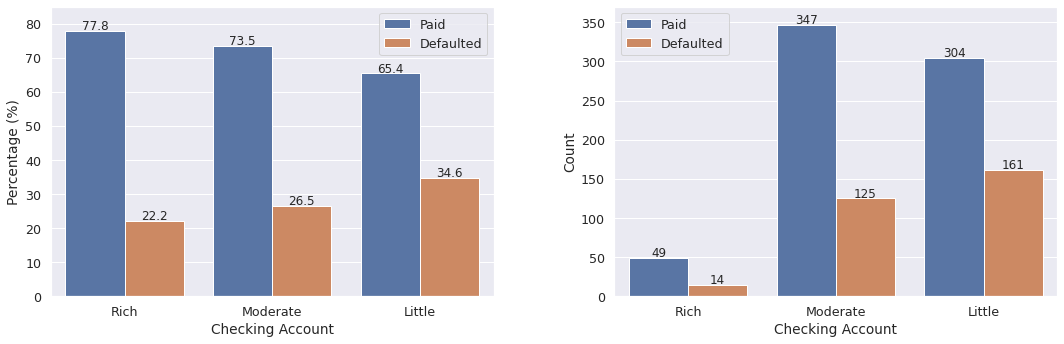

In [217]:
# Making a dataframe out of the crosstab of risk and checking account
ctab = pd.crosstab(df['Checking account'], df['Risk'], normalize = 'index');
ctab_df = ctab.stack().reset_index()
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df.loc[ctab_df['Risk'] == 0, 'Risk'] = 'Paid'
ctab_df.loc[ctab_df['Risk'] == 1, 'Risk'] = 'Defaulted'
ctab_df.value = ctab_df.value*100

plt.figure(figsize = (15, 5))
# Barplot of percentages
plt.subplot(121)
barplt = sns.barplot(data = ctab_df, x = 'Checking account', y = 'value', hue = 'Risk', hue_order = ['Paid', 'Defaulted'],
                     order = ['rich', 'moderate', 'little']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.legend(title = '', loc = 'upper right');
plt.xlabel('Checking Account');
plt.ylabel('Percentage (%)')
barplt.set_xticklabels(labels = ['Rich', 'Moderate', 'Little']);
plt.ylim(0, 85);
# Countplot of counts
plt.subplot(122)
cntplt = sns.countplot(data = df, x = 'Checking account', hue = 'Risk', hue_order = [0, 1], 
                       order = ['rich', 'moderate', 'little']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Checking Account');
plt.ylabel('Count');
cntplt.set_xticklabels(labels = ['Rich', 'Moderate', 'Little']);
plt.legend(labels = ['Paid', 'Defaulted'], title = '', loc = 'upper left');
plt.ylim(0, 370);
plt.tight_layout(w_pad = 5)

**`Risk vs. Saving Accounts`**

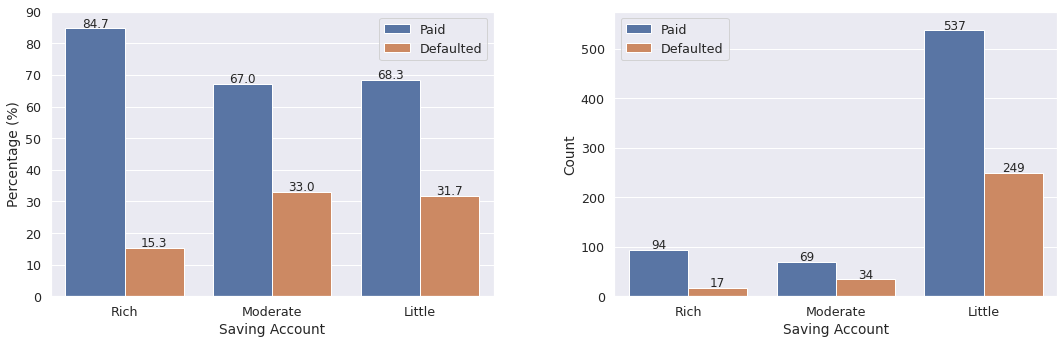

In [225]:
# Making a dataframe out of the crosstab of risk and saving account
ctab = pd.crosstab(df['Saving accounts'], df['Risk'], normalize = 'index');
ctab_df = ctab.stack().reset_index()
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df.loc[ctab_df['Risk'] == 0, 'Risk'] = 'Paid'
ctab_df.loc[ctab_df['Risk'] == 1, 'Risk'] = 'Defaulted'
ctab_df.value = ctab_df.value*100

plt.figure(figsize = (15, 5))
# Barplot of percentages
plt.subplot(121)
barplt = sns.barplot(data = ctab_df, x = 'Saving accounts', y = 'value', hue = 'Risk', hue_order = ['Paid', 'Defaulted'],
                     order = ['rich', 'moderate', 'little']);
countplot_labeling(barplt, ctab_df, perc = False);
plt.legend(title = '', loc = 'upper right');
plt.xlabel('Saving Account');
plt.ylabel('Percentage (%)')
barplt.set_xticklabels(labels = ['Rich', 'Moderate', 'Little']);
plt.ylim(0, 90);
# Countplot of counts
plt.subplot(122)
cntplt = sns.countplot(data = df, x = 'Saving accounts', hue = 'Risk', hue_order = [0, 1], 
                       order = ['rich', 'moderate', 'little']);
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Saving Account');
plt.ylabel('Count');
cntplt.set_xticklabels(labels = ['Rich', 'Moderate', 'Little']);
plt.legend(labels = ['Paid', 'Defaulted'], title = '', loc = 'upper left');
plt.ylim(0, 575);
plt.tight_layout(w_pad = 5)

**`Risk vs. Purpose`**

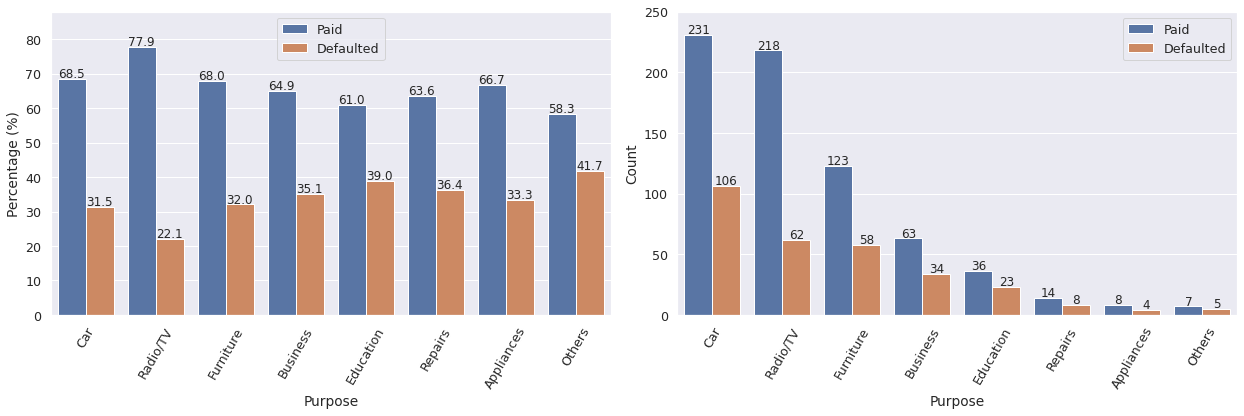

In [243]:
# Making a dataframe out of the crosstab of risk and purpose of loan
ctab = pd.crosstab(df['Purpose'], df['Risk'], normalize = 'index');
ctab_df = ctab.stack().reset_index()
ctab_df.rename(columns = {0: 'value'}, inplace = True)
ctab_df.loc[ctab_df['Risk'] == 0, 'Risk'] = 'Paid'
ctab_df.loc[ctab_df['Risk'] == 1, 'Risk'] = 'Defaulted'
ctab_df.value = ctab_df.value*100

plt.figure(figsize = (17.5, 6))
# Barplot of percentages
plt.subplot(121)
barplt = sns.barplot(data = ctab_df, x = 'Purpose', y = 'value', hue = 'Risk', hue_order = ['Paid', 'Defaulted'],
                     order = df.Purpose.value_counts().index.tolist());
countplot_labeling(barplt, ctab_df, perc = False);
plt.legend(title = '', loc = 'upper center');
plt.xlabel('Purpose');
plt.ylabel('Percentage (%)')
plt.xticks(rotation = 60);
barplt.set_xticklabels(['Car', 'Radio/TV', 'Furniture', 'Business', 'Education',
                        'Repairs', 'Appliances', 'Others']);
plt.ylim(0, 88);
# Countplot of counts
plt.subplot(122)
cntplt = sns.countplot(data = df, x = 'Purpose', hue = 'Risk', hue_order = [0, 1],
                       order = df.Purpose.value_counts().index.tolist());
countplot_labeling(cntplt, df, perc = False);
plt.xlabel('Purpose');
plt.ylabel('Count');
plt.xticks(rotation = 60);
cntplt.set_xticklabels(['Car', 'Radio/TV', 'Furniture', 'Business', 'Education',
                        'Repairs', 'Appliances', 'Others']);
plt.legend(labels = ['Paid', 'Defaulted'], title = '', loc = 'upper right');
plt.ylim(0, 250);
plt.tight_layout()

### Risk vs. Numerical Variables 

**`Risk vs. Age`**

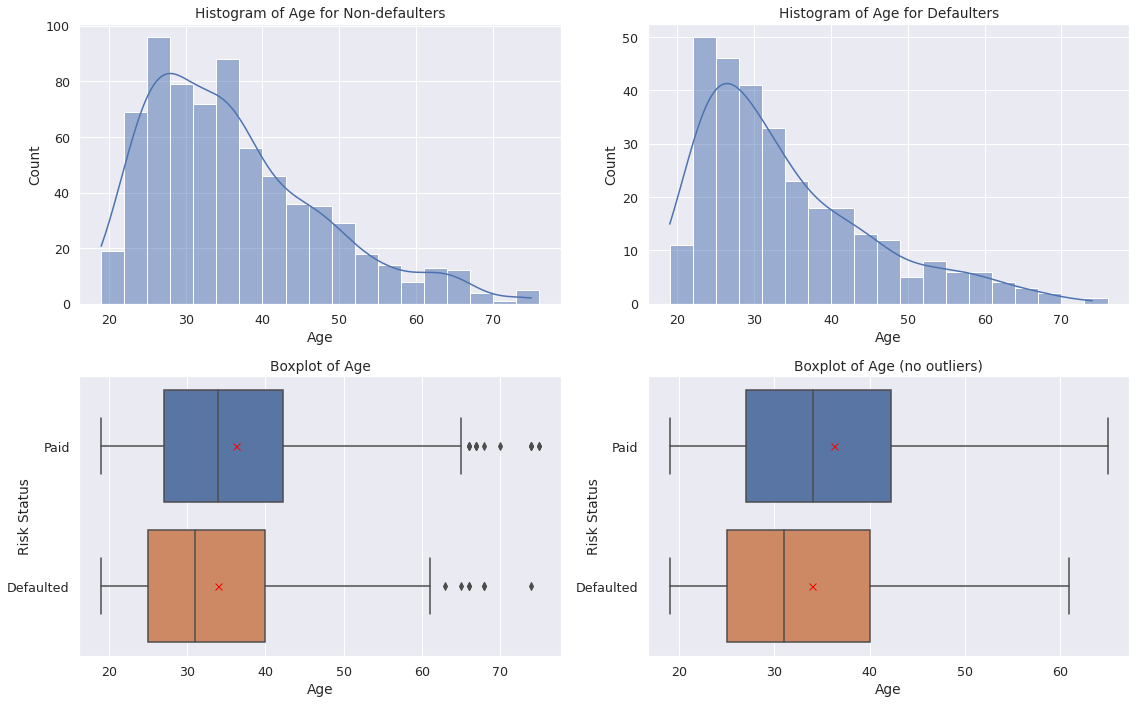

In [286]:
# Distribution of age with risk status 

plt.figure(figsize = (16, 10));
# Histograms
plt.subplot(221)
sns.histplot(data = df.loc[df.Risk == 0], x = 'Age', kde = True, binwidth = 3);
plt.title('Histogram of Age for Non-defaulters')
plt.subplot(222)
sns.histplot(data = df.loc[df.Risk == 1], x = 'Age', kde = True, binwidth = 3);
plt.title('Histogram of Age for Defaulters');
# Boxplots
plt.subplot(223)
bxplt = sns.boxplot(data = df, x = 'Age', y = 'Risk', orient = 'h', showfliers = True, showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '7'});
plt.title('Boxplot of Age')
bxplt.set_yticklabels(['Paid', 'Defaulted']);
plt.ylabel('Risk Status');
bxplt.yaxis.labelpad = -25
plt.subplot(224)
bxplt = sns.boxplot(data = df, x = 'Age', y = 'Risk', orient = 'h', showfliers = False, showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '7'});
plt.title('Boxplot of Age (no outliers)');
bxplt.set_yticklabels(['Paid', 'Defaulted']);
plt.ylabel('Risk Status');
bxplt.yaxis.labelpad = -25
plt.tight_layout()

**`Risk vs. Credit Amount`**

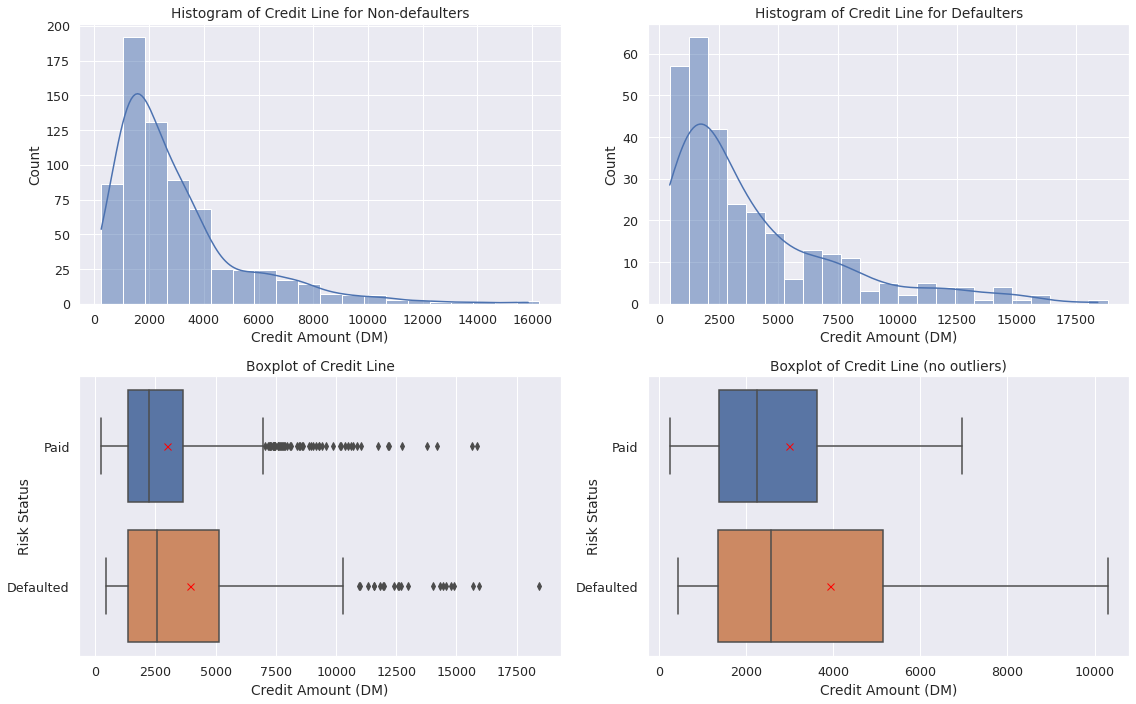

In [289]:
# Distribution of credit amount with risk status (credit in Deutsche Mark)

plt.figure(figsize = (16, 10));
# Histograms
plt.subplot(221)
sns.histplot(data = df.loc[df['Risk'] == 0], x = 'Credit amount', kde = True, binwidth = 800);
plt.xlabel('Credit Amount (DM)');
plt.title('Histogram of Credit Line for Non-defaulters')
plt.subplot(222)
sns.histplot(data = df.loc[df['Risk'] == 1], x = 'Credit amount', kde = True, binwidth = 800);
plt.xlabel('Credit Amount (DM)');
plt.title('Histogram of Credit Line for Defaulters');
# Boxplots
plt.subplot(223)
bxplt = sns.boxplot(data = df, x = 'Credit amount', y = 'Risk', orient = 'h', showfliers = True, showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '7'});
plt.title('Boxplot of Credit Line')
bxplt.set_yticklabels(['Paid', 'Defaulted']);
plt.xlabel('Credit Amount (DM)');
plt.ylabel('Risk Status');
bxplt.yaxis.labelpad = -25
plt.subplot(224)
bxplt = sns.boxplot(data = df, x = 'Credit amount', y = 'Risk', orient = 'h', showfliers = False, showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '7'});
plt.title('Boxplot of Credit Line (no outliers)');
bxplt.set_yticklabels(['Paid', 'Defaulted']);
plt.xlabel('Credit Amount (DM)');
plt.ylabel('Risk Status');
bxplt.yaxis.labelpad = -25
plt.tight_layout()

**`Risk vs. Loan Duration`**

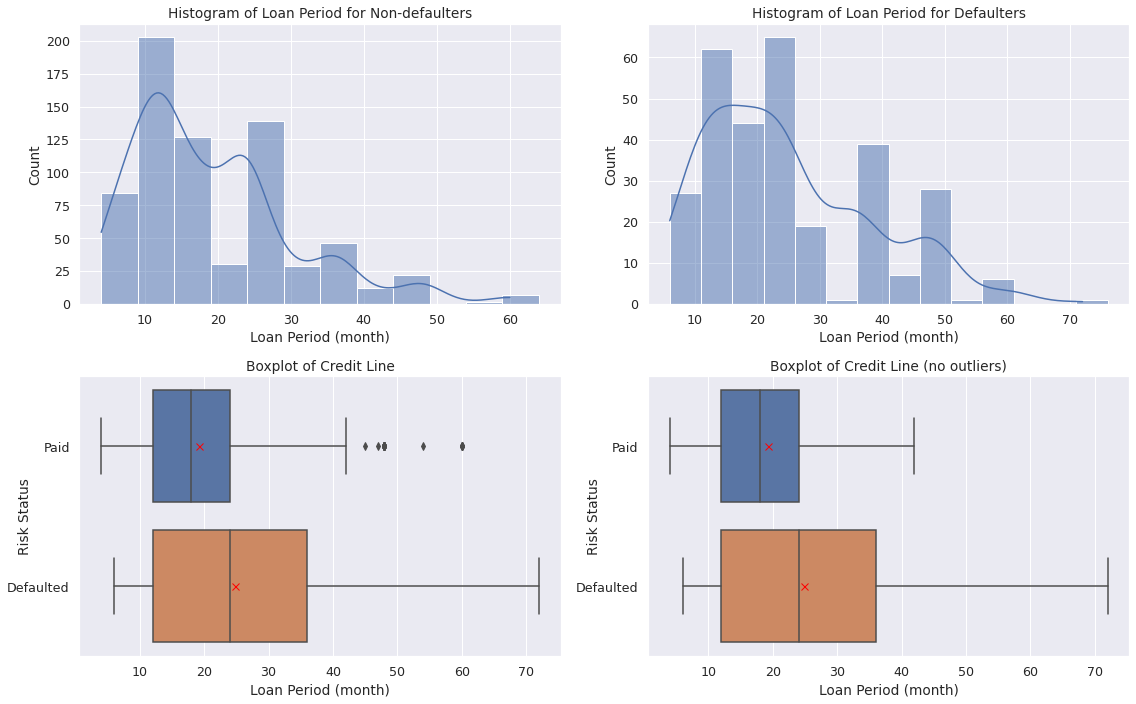

In [298]:
# Distribution of credit amount with loan duration 

plt.figure(figsize = (16, 10));
# Histograms
plt.subplot(221)
sns.histplot(data = df.loc[df['Risk'] == 0], x = 'Duration', kde = True, binwidth = 5);
plt.xlabel('Loan Period (month)');
plt.title('Histogram of Loan Period for Non-defaulters')
plt.subplot(222)
sns.histplot(data = df.loc[df['Risk'] == 1], x = 'Duration', kde = True, binwidth = 5);
plt.xlabel('Loan Period (month)');
plt.title('Histogram of Loan Period for Defaulters');
# Boxplots
plt.subplot(223)
bxplt = sns.boxplot(data = df, x = 'Duration', y = 'Risk', orient = 'h', showfliers = True, showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '7'});
plt.title('Boxplot of Credit Line')
bxplt.set_yticklabels(['Paid', 'Defaulted']);
plt.xlabel('Loan Period (month)');
plt.ylabel('Risk Status');
bxplt.yaxis.labelpad = -25
plt.subplot(224)
bxplt = sns.boxplot(data = df, x = 'Duration', y = 'Risk', orient = 'h', showfliers = False, showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '7'});
plt.title('Boxplot of Credit Line (no outliers)');
bxplt.set_yticklabels(['Paid', 'Defaulted']);
plt.xlabel('Loan Period (month)');
plt.ylabel('Risk Status');
bxplt.yaxis.labelpad = -25
plt.tight_layout()

## Logistic Regression

### Developing Necessary Functions for Model Evaluation and Treatment

In [367]:
# Defining functions for multicollinearity calculation and treatment
def vif_calculator(X, drop_dummy_const = True):
  '''This function receives the predictors and calculates the VIF for each of them.'''

  vif_results = pd.DataFrame({'Feature': X.columns.tolist()})
  for i in range(X.shape[1]):
    vif_results.loc[i, 'VIF'] = variance_inflation_factor(X.values, i)

  dummy_const_indices = []
  for i, text in enumerate(X.columns.tolist()):
    if (text == 'const' or '_' in text):
      dummy_const_indices.append(i)

  if(drop_dummy_const == True):
    vif_results.drop(index = dummy_const_indices, axis = 0, inplace = True)
    vif_results.reset_index(drop = True, inplace = True)  

  return vif_results

def vif_treatment(vif_results, X_train, y_train, thresh = 0.5):
  high_vif_cols = vif_results['Feature'].loc[vif_results.VIF > 5].tolist()
  vif_treatment_res = pd.DataFrame(columns = ['Dropped Column', 'Accuracy', 'Recall', 'Precision'])

  for i, text in enumerate(high_vif_cols):
    X_train_temp = X_train.drop(columns = text, axis = 1)
    model_temp = (sm.Logit(y_train, X_train_temp)).fit()
    y_pred = model_temp.predict(X_train_temp)
    y_pred = np.round(y_pred > thresh)
    accuracy = accuracy_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    vif_treatment_res.iloc[i, 0] = text    
    vif_treatment_res.iloc[i, 1:] = [accuracy, recall, precision] 

  return vif_treatment_res

In [378]:
# Defining a function for detecting statistically insignificant columns
def highp_removal(model, X_train, y_train):
  '''This function drops all columns whose p-value >= 0.5 one by one,
  until all predictors have p-value < 0.05.'''
  highp_cols = []
  while(model.pvalues.max() >= 0.05): 
    p_max_col = model.pvalues.idxmax()
    highp_cols.append(p_max_col)
    X_train_temp = X_train.drop(columns = highp_cols, axis = 1)
    model = (sm.Logit(y_train, X_train_temp)).fit(disp = False)

  return highp_cols

In [453]:
# Defining a function for evaluating the performance of the model
def model_performance(model, X_train, X_test, y_train, y_test, thresh = 0.5):
  '''This function returns various performance metrics suitable for logistic regression models.'''

  model_metrics = pd.DataFrame(index = ['Train', 'Test'], 
                               columns = ['Accuracy', 'Recall', 'Precision', 'Specificity', 'F1', 'AUC'])
  y_pred_train = np.round(model.predict(X_train) > thresh)
  y_pred_test = np.round(model.predict(X_test) > thresh)

  model_metrics.loc['Train', :] = [accuracy_score(y_train, y_pred_train), recall_score(y_train, y_pred_train), 
                                   precision_score(y_train, y_pred_train), recall_score(y_train, y_pred_train, pos_label = 0),
                                   f1_score(y_train, y_pred_train), roc_auc_score(y_train, model.predict(X_train))]

  model_metrics.loc['Test', :] = [accuracy_score(y_test, y_pred_test), recall_score(y_test, y_pred_test), 
                                   precision_score(y_test, y_pred_test), recall_score(y_test, y_pred_test, pos_label = 0),
                                   f1_score(y_test, y_pred_test), roc_auc_score(y_test, model.predict(X_test))]
  return model_metrics

### Developing the Initial Logistic Regression Model

In [533]:
# Splitting the dataset into target variable and predictors
y = df['Risk']
X = df.drop(columns = 'Risk', axis = 1)

# Adding the intercept and dummy variables
X = add_constant(X)
X = pd.get_dummies(X, X.select_dtypes(include = ['object', 'category']).columns.tolist(), drop_first = True)

# Splitting data into training and testing sets with a 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.3, stratify = y) 

X_train = X_train.astype(float) 
X_test = X_test.astype(float) 

# Ensuring the fractions of risk status are identical among train and test
print(y_train.value_counts(1))
print(y_test.value_counts(1))

0   0.70
1   0.30
Name: Risk, dtype: float64
0   0.70
1   0.30
Name: Risk, dtype: float64


In [534]:
# Peeking the training data
X_train.head()

,const,Age,Credit amount,Duration,Sex_male,Job_skilled,Job_unskilled_and_non-resident,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
913,1.00,28.00,2142.00,11.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
136,1.00,27.00,8613.00,27.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
802,1.00,24.00,4272.00,20.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
374,1.00,60.00,14782.00,60.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
295,1.00,26.00,9960.00,48.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [535]:
# Peeking the testing data
X_test.head()

,const,Age,Credit amount,Duration,Sex_male,Job_skilled,Job_unskilled_and_non-resident,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
734,1.00,37.00,3380.00,4.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
915,1.00,32.00,18424.00,48.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
462,1.00,34.00,3017.00,12.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
457,1.00,35.00,3386.00,12.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
843,1.00,50.00,1559.00,24.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [536]:
# Building the logistic regression model
lg_model1 = (sm.Logit(y_train, X_train)).fit()
print(lg_model1.summary())

Optimization terminated successfully.
         Current function value: 0.556534
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  700
Model:                          Logit   Df Residuals:                      680
Method:                           MLE   Df Model:                           19
Date:                Fri, 26 Aug 2022   Pseudo R-squ.:                 0.08894
Time:                        02:13:15   Log-Likelihood:                -389.57
converged:                       True   LL-Null:                       -427.61
Covariance Type:            nonrobust   LLR p-value:                 8.784e-09
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.4503      0.676     -0.667     

### Checking Multicollinearity

In [537]:
# VIFs of numerical predictors
VIF_Results = vif_calculator(X_train)
VIF_Results 

,Feature,VIF
0,Age,1.21
1,Credit amount,1.94
2,Duration,1.76


In [538]:
# Ensuring none of the dummy or constant variables has a NaN or Inf VIF
VIF_Results_full = vif_calculator(X_train)
print('There are {} predictors with NaN VIFs.'.format(VIF_Results_full.isnull().sum().sum()))
print('There are {} predictors with inf VIFs.'.format(VIF_Results_full.loc[VIF_Results_full.VIF == np.inf].shape[0]))

There are 0 predictors with NaN VIFs.
There are 0 predictors with inf VIFs.


### Removing Statistically Insignificant Predictors

We first drop dummy variables for which all categories reveal p-values greater than or equal to 0.05, before passing the resulting model to our in-house function. 

In [539]:
# Dropping all job categories at once
Job_cols = ['Job_skilled', 'Job_unskilled_and_non-resident']

X_train2 = X_train.drop(columns = Job_cols, axis = 1)
y_train2 = y_train.copy()

# Building the logistic regression model
lg_model2 = (sm.Logit(y_train2, X_train2)).fit()
print(lg_model2.summary())

Optimization terminated successfully.
         Current function value: 0.556932
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  700
Model:                          Logit   Df Residuals:                      682
Method:                           MLE   Df Model:                           17
Date:                Fri, 26 Aug 2022   Pseudo R-squ.:                 0.08829
Time:                        02:13:20   Log-Likelihood:                -389.85
converged:                       True   LL-Null:                       -427.61
Covariance Type:            nonrobust   LLR p-value:                 2.382e-09
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.5548      0.623     -0.891      0.373   

In [540]:
# Dropping all housing categories at once
Housing_cols = ['Housing_own',  'Housing_rent']

X_train3 = X_train2.drop(columns = Housing_cols, axis = 1)
y_train3 = y_train2.copy()

# Building the logistic regression model
lg_model3 = (sm.Logit(y_train3, X_train3)).fit()
print(lg_model3.summary())

Optimization terminated successfully.
         Current function value: 0.558365
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  700
Model:                          Logit   Df Residuals:                      684
Method:                           MLE   Df Model:                           15
Date:                Fri, 26 Aug 2022   Pseudo R-squ.:                 0.08594
Time:                        02:13:21   Log-Likelihood:                -390.86
converged:                       True   LL-Null:                       -427.61
Covariance Type:            nonrobust   LLR p-value:                 1.056e-09
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.4109      0.459     -0.896      0.370   

In [541]:
# Dropping all housing categories at once
Saving_cols = ['Saving accounts_moderate',  'Saving accounts_rich']

X_train4 = X_train3.drop(columns = Saving_cols, axis = 1)
y_train4 = y_train3.copy()

# Building the logistic regression model
lg_model4 = (sm.Logit(y_train4, X_train4)).fit()
print(lg_model4.summary())

Optimization terminated successfully.
         Current function value: 0.561611
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  700
Model:                          Logit   Df Residuals:                      686
Method:                           MLE   Df Model:                           13
Date:                Fri, 26 Aug 2022   Pseudo R-squ.:                 0.08063
Time:                        02:13:22   Log-Likelihood:                -393.13
converged:                       True   LL-Null:                       -427.61
Covariance Type:            nonrobust   LLR p-value:                 1.249e-09
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.3689      0.454     -0.813      0.416   

#### Notes: 
For the remaning dummy variables, at least one category has a p-value less than 0.05. Therefore, we can now pass the last model to the in-house function for finding statistically insignificant predictors. 

In [542]:
highp_cols = highp_removal(lg_model4, X_train4, y_train4)
highp_cols

['Purpose_vacation/others',
 'Purpose_repairs',
 'Purpose_domestic appliances',
 'const',
 'Purpose_education',
 'Credit amount',
 'Checking account_rich',
 'Purpose_car',
 'Purpose_furniture/equipment']

In [543]:
# Const should always be included to develop a logistic regression model
highp_cols.remove('const')
# Making a list of all cols that should be dropped to attain a model with no statistically insignificant predictors
cols_to_drop = highp_cols + Job_cols + Housing_cols + Saving_cols


# Building a new model that has no predictor with p-vale >= 0.05 logistic regression model
X_train5 = X_train.drop(columns = cols_to_drop, axis = 1)
y_train5 = y_train.copy()

lg_model5 = (sm.Logit(y_train5, X_train5)).fit()
print(lg_model5.summary())

Optimization terminated successfully.
         Current function value: 0.566127
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  700
Model:                          Logit   Df Residuals:                      694
Method:                           MLE   Df Model:                            5
Date:                Fri, 26 Aug 2022   Pseudo R-squ.:                 0.07324
Time:                        02:13:25   Log-Likelihood:                -396.29
converged:                       True   LL-Null:                       -427.61
Covariance Type:            nonrobust   LLR p-value:                 3.469e-12
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5593      0.340     -1.646      0.100      -1.

### Evaluating the Performance of the Final Model

In [544]:
# Rebuilding the testing set by dropping all the removed features from the training
X_test5 = X_test.drop(columns = cols_to_drop, axis = 1)
y_test5 = y_test.copy()

M5_performance = model_performance(lg_model5, X_train5, X_test5, y_train5, y_test5)
M5_performance

,Accuracy,Recall,Precision,Specificity,F1,AUC
Train,0.72,0.18,0.61,0.95,0.27,0.68
Test,0.72,0.23,0.57,0.92,0.33,0.64


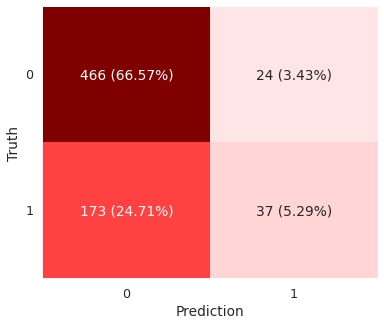

In [545]:
# Generating the confusion matrix for training set

y_pred = np.round(lg_model5.predict(X_train5) > 0.5)
cm = confusion_matrix(y_train5, y_pred)

# Creating labels of the heatmap
val_perc = []  # contains the exact value + percentage
for i in range(len(cm.flatten())):
  val_perc.append(str(cm.flatten()[i]) + " (" + str(np.round(100*cm.flatten()[i]/cm.flatten().sum(), 2)) + "%)")
val_perc = np.asarray(val_perc)
val_perc = val_perc.reshape(2,2)

# Plotting the confusion matrix in the form of a heatmap
plt.figure(figsize = (6, 5))
sns.heatmap(cm, fmt = "", annot = val_perc, cmap = 'seismic', vmin = -max(np.abs(cm.flatten())), 
            vmax = max(np.abs(cm.flatten())), cbar = False);
plt.xlabel('Prediction');
plt.ylabel('Truth');
plt.yticks(rotation = 0);

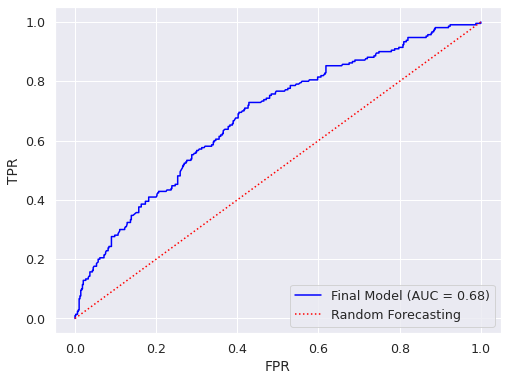

In [546]:
# Generating ROC curves
AUC = roc_auc_score(y_train5, lg_model5.predict(X_train5))
fpr, tpr, thresholds = roc_curve(y_train5, lg_model5.predict(X_train5))

plt.figure(figsize = (8, 6));
plt.plot(fpr, tpr, color = 'blue'); 
plt.plot([0, 1], [0, 1], linestyle = ':', color = 'red'); 
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.legend(['Final Model (AUC = {})'.format(round(AUC,2)), 'Random Forecasting'], loc = 'lower right');

Optimal Threshold = 0.36


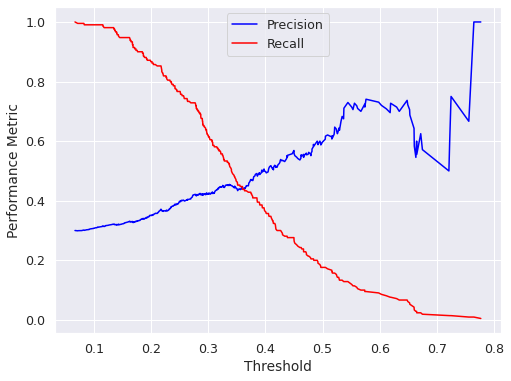

In [547]:
# Obtaining optimal threshold using precision-recall curves
precision, recall, thresholds = precision_recall_curve(y_train5, lg_model5.predict(X_train5))

plt.figure(figsize = (8, 6));
plt.plot(thresholds, precision[:-1], color = 'blue'); 
plt.plot(thresholds, recall[:-1], color = 'red'); 
plt.xlabel('Threshold');
plt.ylabel('Performance Metric');
plt.legend(['Precision', 'Recall'], loc = 'upper center');

# Finding optimal threshold for which recall = precision
for i in range(len(precision[:-1])):
  if(precision[i] == recall[i]):
    optimal_tres = thresholds[i]
    break

print('Optimal Threshold =', round(optimal_tres, 3));

In [548]:
# Recalculating the model's performance with the optimal threshold
X_test5 = X_test.drop(columns = cols_to_drop, axis = 1)
y_test5 = y_test.copy()

M5_performance = model_performance(lg_model5, X_train5, X_test5, y_train5, y_test5, 
                                   thresh = optimal_tres)
M5_performance

,Accuracy,Recall,Precision,Specificity,F1,AUC
Train,0.66,0.44,0.44,0.76,0.44,0.68
Test,0.62,0.43,0.38,0.70,0.40,0.64


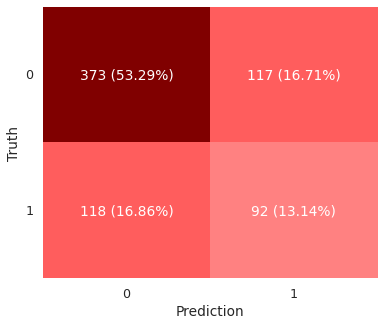

In [549]:
# Generating the confusion matrix for training set with the optimal threshold

y_pred = np.round(lg_model5.predict(X_train5) > optimal_tres)
cm = confusion_matrix(y_train5, y_pred)

# Creating labels of the heatmap
val_perc = []  # contains the exact value + percentage
for i in range(len(cm.flatten())):
  val_perc.append(str(cm.flatten()[i]) + " (" + str(np.round(100*cm.flatten()[i]/cm.flatten().sum(), 2)) + "%)")
val_perc = np.asarray(val_perc)
val_perc = val_perc.reshape(2,2)

# Plotting the confusion matrix in the form of a heatmap
plt.figure(figsize = (6, 5))
sns.heatmap(cm, fmt = "", annot = val_perc, cmap = 'seismic', vmin = -max(np.abs(cm.flatten())), 
            vmax = max(np.abs(cm.flatten())), cbar = False);
plt.xlabel('Prediction');
plt.ylabel('Truth');
plt.yticks(rotation = 0);

### Interpretting the Coefficients

Suppose b is the coeffcient of a certain predictor in the model. Then, **(exp(b) - 1)*100** returns the percentage of the change in the target variable (probability of the risk) if all other variables have been retained constant. 

In [550]:
# Calculating odds and their changes using the coefficient of the final model 
features = lg_model5.params.index.tolist()[1:]
Odds_df = pd.DataFrame(index = ['Odds', 'Odds Change (%)'], columns = features)

Odds_df.iloc[0, :] = np.exp(lg_model5.params[1:])
Odds_df.iloc[1, :] = (np.exp(lg_model5.params[1:]) - 1)*100
Odds_df

,Age,Duration,Sex_male,Checking account_moderate,Purpose_radio/TV
Odds,0.98,1.05,0.63,0.63,0.54
Odds Change (%),-1.60,4.53,-37.48,-37.05,-45.75
